In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as pre_in_vgg16
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.metrics import categorical_crossentropy
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import class_weight
from google.colab.patches import cv2_imshow
from shutil import copyfile, rmtree
from google.colab import drive
from google.colab import files
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import zipfile
import random
import cv2
import os

In [ ]:
# Download dataset https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
# first download kaggle api token from account section of your kaggle profile and then upload it when run this cell
!pip install -q kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'tawsifurrahman/tuberculosis-tb-chest-xray-dataset'

Saving kaggle.json to kaggle.json
 98% 649M/663M [00:19<00:00, 53.3MB/s]
100% 663M/663M [00:19<00:00, 34.9MB/s]


In [ ]:
# Extract dataset zip file
local_zip = 'tuberculosis-tb-chest-xray-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [ ]:
# make directories for storing training and test sets
try:
    parent_dir = './tb-xray-database/'
    os.mkdir(parent_dir)
    training_path = os.path.join(parent_dir, "training")
    validation_path = os.path.join(parent_dir, "validation")
    testing_path = os.path.join(parent_dir, "testing")
    os.mkdir(training_path)
    os.mkdir(validation_path)
    os.mkdir(testing_path)
    os.mkdir(os.path.join(training_path, "normal"))
    os.mkdir(os.path.join(training_path, "tb"))
    os.mkdir(os.path.join(validation_path, "normal"))
    os.mkdir(os.path.join(validation_path, "tb"))
    os.mkdir(os.path.join(testing_path, "normal"))
    os.mkdir(os.path.join(testing_path, "tb"))
except OSError:
    print("couldn't make it")
    pass

In [ ]:
# Split into training and test sets
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, TRAIN_SIZE, VALID_SIZE):
    path_list = os.listdir(SOURCE)# file names in SOURCE
    length = len(path_list)
    count = 0
    for file in random.sample(path_list, length):
        file_path = os.path.join(SOURCE, file)
        if (os.path.getsize(file_path) != 0):
            if (count < TRAIN_SIZE*length):
                copyfile(file_path, os.path.join(TRAINING, file))
                count+=1
            elif (count >= TRAIN_SIZE*length and count < ((TRAIN_SIZE+VALID_SIZE)*length)):
                copyfile(file_path, os.path.join(VALIDATION, file))
                count+=1
            else:
                copyfile(file_path, os.path.join(TESTING, file))

# Define path to the data directory
data_dir = Path('TB_Chest_Radiography_Database/')
NORMAL_SOURCE_DIR = data_dir / 'Normal'
TRAINING_NORMAL_DIR = os.path.join(training_path, "normal")
VALIDATION_NORMAL_DIR = os.path.join(validation_path, "normal")
TESTING_NORMAL_DIR = os.path.join(testing_path, "normal")

TB_SOURCE_DIR = data_dir / 'Tuberculosis'
TRAINING_TB_DIR = os.path.join(training_path, "tb")
VALIDATION_TB_DIR = os.path.join(validation_path, "tb")
TESTING_TB_DIR = os.path.join(testing_path, "tb")

train_size = 0.7
valid_size = 0.2
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, VALIDATION_NORMAL_DIR, TESTING_NORMAL_DIR, train_size, valid_size)
split_data(TB_SOURCE_DIR, TRAINING_TB_DIR, VALIDATION_TB_DIR, TESTING_TB_DIR, train_size, valid_size)

In [ ]:
num_normal_train = len(os.listdir(TRAINING_NORMAL_DIR))
num_normal_valid = len(os.listdir(VALIDATION_NORMAL_DIR))
num_normal_test = len(os.listdir(TESTING_NORMAL_DIR))
num_tb_train = len(os.listdir(TRAINING_TB_DIR))
num_tb_valid = len(os.listdir(VALIDATION_TB_DIR))
num_tb_test = len(os.listdir(TESTING_TB_DIR))
print("Training Noraml images:", num_normal_train)
print("Validation Normal images:", num_normal_valid)
print("Testing Normal images:", num_normal_test)
print("Training TB images:", num_tb_train)
print("Validation TB images:", num_tb_valid)
print("Testing TB images:", num_tb_test)

Training Noraml images: 2450
Validation Normal images: 700
Testing Normal images: 350
Training TB images: 490
Validation TB images: 140
Testing TB images: 70


In [ ]:
IMAGE_SIZE = [224, 224] #Default image size for VGG16
BS = 32
EPOCHS = 20

In [ ]:
# Path for train, validation and test datasets
train_path = './tb-xray-database/training'
valid_path = './tb-xray-database/validation'
test_path = './tb-xray-database/testing'


folders = glob('./tb-xray-database/training/*') #Get number of classes
# ImageDataGenerator can help perform augumentation on existing images. This way, we get more diverse train set but we don't perform any augmentation in this project
datagen = ImageDataGenerator(rescale = 1./255)
#Through flow_from_directory - we create an array of images that can be used for training. 
training_set = datagen.flow_from_directory(train_path,
                                           target_size = IMAGE_SIZE,
                                           batch_size= BS,
                                           class_mode='categorical')
validation_set = datagen.flow_from_directory(valid_path,
                                           target_size = IMAGE_SIZE,
                                           batch_size= BS,
                                           class_mode='categorical',
                                           shuffle=False)
testing_set = datagen.flow_from_directory(test_path,
                                           target_size = IMAGE_SIZE,
                                           batch_size= BS,
                                           class_mode='categorical',
                                           shuffle=False)

Found 2940 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [ ]:
# label of each class
print(training_set.class_indices)

{'normal': 0, 'tb': 1}


In [ ]:
# Create a VGG16 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) 
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False
head = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
head = Dense(64, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(len(folders), activation='softmax')(head) # We have 2 classes, and so, the prediction is being done on len(folders) - 2 classes
#Creating model object 
model = Model(inputs=vgg.input, outputs=head)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

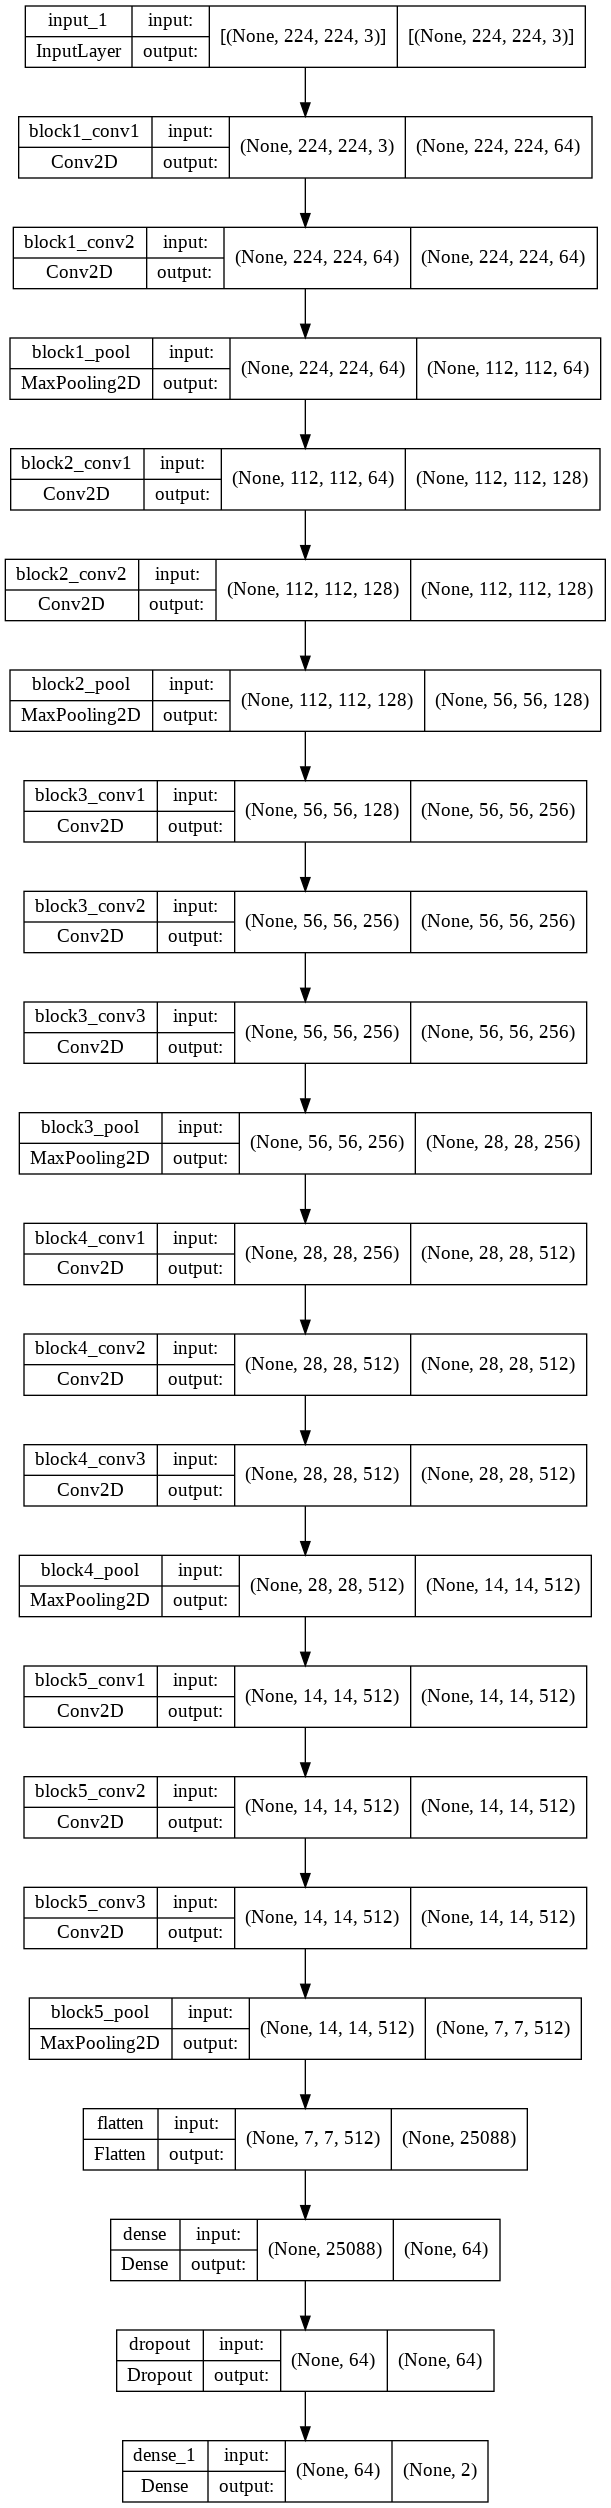

In [ ]:
#plot model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# we use class weight because of imbalnce data
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(training_set.classes), y=training_set.classes)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.6, 1: 3.0}


In [ ]:
#Compile the model 
model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# define checkpoint for save weight just when val_accuracy improved
checkpoint = ModelCheckpoint(filepath="model.h5",
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True)

In [ ]:
history = model.fit(training_set, 
                    validation_data=validation_set, 
                    steps_per_epoch=(training_set.n//BS),
                    validation_steps=(validation_set.n//BS),
                    epochs=EPOCHS, 
                    batch_size=BS, 
                    class_weight=class_weights,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/20
91/91 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8446
Epoch 1: val_accuracy improved from -inf to 0.97957, saving model to model.h5
91/91 [==============================] - 52s 415ms/step - loss: 0.4455 - accuracy: 0.8446 - val_loss: 0.0807 - val_accuracy: 0.9796
Epoch 2/20
91/91 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9519
Epoch 2: val_accuracy improved from 0.97957 to 0.98558, saving model to model.h5
91/91 [==============================] - 37s 409ms/step - loss: 0.1324 - accuracy: 0.9519 - val_loss: 0.0574 - val_accuracy: 0.9856
Epoch 3/20
91/91 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9598
Epoch 3: val_accuracy improved from 0.98558 to 0.99159, saving model to model.h5
91/91 [==============================] - 36s 398ms/step - loss: 0.0963 - accuracy: 0.9598 - val_loss: 0.0275 - val_accuracy: 0.9916
Epoch 4/20
91/91 [==============================] - ETA: 0s - loss: 0.0717 - accur

In [ ]:
# save model
model.save('TBClassification.h5', save_format="h5")

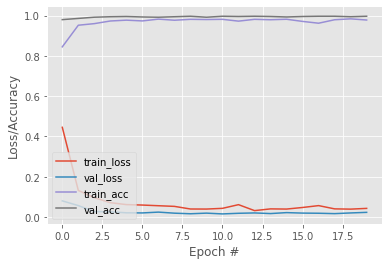

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('TBClassification training loss and accuracy')

In [ ]:
# prediction on testing_set
predIdxs = model.predict(testing_set, batch_size=BS, verbose=1)

14/14 [==============================] - 5s 362ms/step


In [ ]:
# show classificaiton report
predIdx = np.argmax(predIdxs, axis=1)
print(classification_report(testing_set.labels, 
                            predIdx,
                            target_names = ['Normal', 'TB']))

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       350
          TB       0.97      0.99      0.98        70

    accuracy                           0.99       420
   macro avg       0.98      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



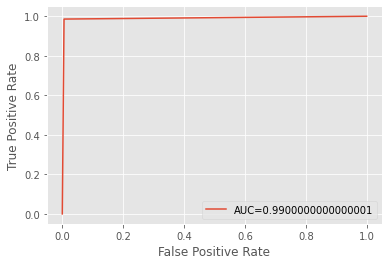

<Figure size 432x288 with 0 Axes>

In [ ]:
#define metrics
y_pred_proba = np.argmax(predIdxs, axis=1)
fpr, tpr, _ = roc_curve(testing_set.labels,  y_pred_proba)
auc = roc_auc_score(testing_set.labels, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
plt.savefig("roc curve")

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testing_set.labels, predIdx)
total = sum(sum(cm))
tp = cm[0, 0]
fn = cm[0, 1]
tn = cm[1, 1]
fp = cm[1, 0]
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[348   2]
 [  1  69]]
accuracy: 0.9929
sensitivity: 0.9943
specificity: 0.9857


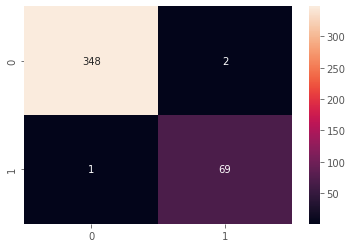

In [ ]:
# show heatmap of testing data prediction(tp, tn, fp, fn)
f = sns.heatmap(cm, annot=True, fmt='d')

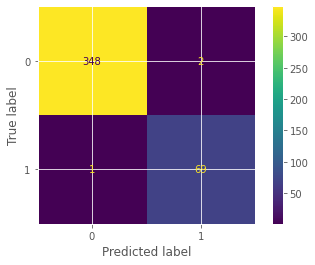

In [ ]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
# precision and recall for multiple threshold
precisions , recalls , fscores = [], [], []
for th in np.arange(0.01,1,0.01):
    y_pred_temp = predIdxs > th
    y_pred_temp = np.argmax(y_pred_temp, axis=1)
    precision = precision_score(testing_set.labels, y_pred_temp, average='binary')
    recall = recall_score(testing_set.labels, y_pred_temp, average='binary')
    fscore = f1_score(testing_set.labels, y_pred_temp, average='binary')
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)

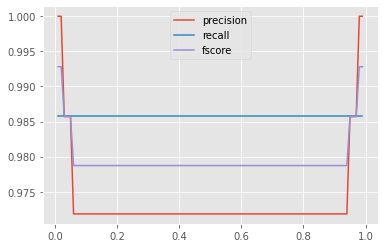

In [ ]:
plt.plot(np.arange(0.01,1,0.01), precisions, label='precision')
plt.plot(np.arange(0.01,1,0.01), recalls, label='recall')
plt.plot(np.arange(0.01,1,0.01), fscores, label='fscore')
plt.legend()
plt.show()

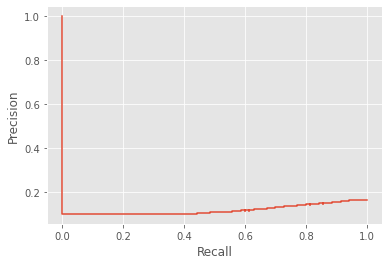

In [ ]:
# show precision/ recall diagram
precision, recall, _ = precision_recall_curve(testing_set.labels, np.max(predIdxs, axis=1))
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [ ]:
# test random image form testing_set
# load the original image from disk and then
# resize the image to its target dimensions
path = "tb-xray-database/testing/"
random_image = random.randint(0, testing_set.n)
filename = path + testing_set.filenames[random_image]
orig = cv2.imread(filename)
resized = cv2.resize(orig, IMAGE_SIZE)
# load the input image from disk and preprocess it
image = load_img(filename, target_size=IMAGE_SIZE)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = pre_in_vgg16(image)

In [ ]:
# use the network to make predictions on the input image and find
# the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])
label = 'Normal' if i == 0 else "TB"
print("[INFO] \nPredicted Label : {}".format(label))
print("True Label :", filename.split(os.path.sep)[-2])

[INFO] 
Predicted Label : Normal
True Label : normal


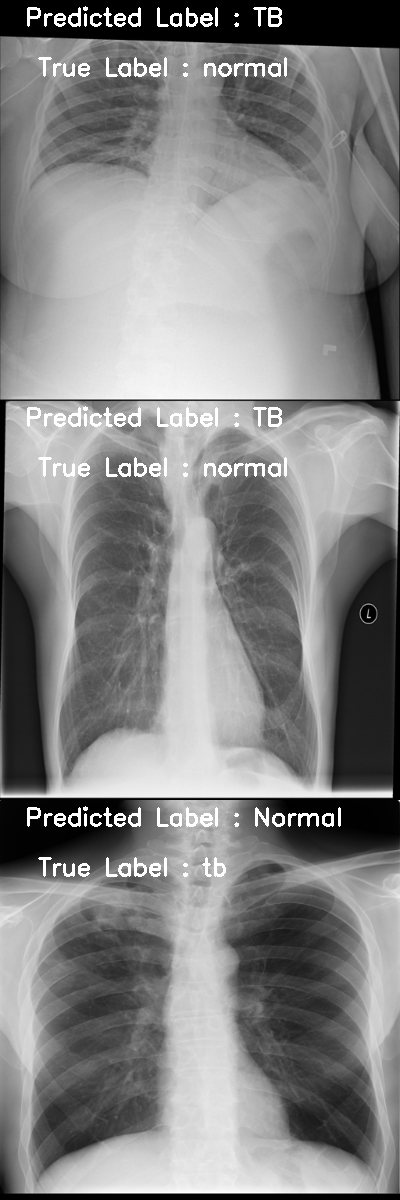

In [ ]:
# find wrong predictions
indices = [i for i,v in enumerate(predIdx) if predIdx[i]!=testing_set.labels[i]]
subset_of_wrongly_predicted = [[testing_set.filenames[i],i] for i in indices ]
wrong_images = []
for img in subset_of_wrongly_predicted:
  filename = path + img[0]
  orig = cv2.imread(filename)
  i = predIdx[img[1]]
  label = 'Normal' if i == 0 else "TB"
  orig = cv2.resize(orig, (400, 400))
  text = "Predicted Label : {}\n True Label : {}".format(label, filename.split(os.path.sep)[-2])
  y0, dy = 25, 50
  for i, line in enumerate(text.split('\n')):
      y = y0 + i*dy
      # cv2.putText(orig, line, (50, y ), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
      cv2.putText(orig, line, (25, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
  # cv2.putText(orig, , (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
  wrong_images.append(orig)
output = np.vstack(wrong_images)
cv2_imshow(output)